In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

/Users/lichengxuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
archetype = gpd.read_file('BS_ref/archetype.geojson')
initial_guess = gpd.read_file('BS_ref/initial_guess.geojson')
prototype = gpd.read_file('BS_ref/prototype_building.geojson')

Skipping field Heating[KWh][Mth]: unsupported OGR type: 3
Skipping field Cooling[KWh][Mth]: unsupported OGR type: 3
Skipping field Equipment[KWh][Mth]: unsupported OGR type: 3
Skipping field Lighting[KWh][Mth]: unsupported OGR type: 3
Skipping field HotWater[KWh][Mth]: unsupported OGR type: 3
Skipping field GasEquipment[KWh][Mth]: unsupported OGR type: 3
Skipping field Auxiliary[KWh][Mth]: unsupported OGR type: 3
Skipping field Gas[kWh][Mth]: unsupported OGR type: 3
Skipping field Electricity[kWh][Mth]: unsupported OGR type: 3
Skipping field CO2[kg][Mth]: unsupported OGR type: 3
Skipping field CO2_Gas[kg][Mth]: unsupported OGR type: 3
Skipping field CO2_Electricity[kg][Mth]: unsupported OGR type: 3
Skipping field WWR_E_S_W_N_R_ESL: unsupported OGR type: 3
Skipping field Heating[KWh][Mth]: unsupported OGR type: 3
Skipping field Cooling[KWh][Mth]: unsupported OGR type: 3
Skipping field Equipment[KWh][Mth]: unsupported OGR type: 3
Skipping field Lighting[KWh][Mth]: unsupported OGR type: 3

In [ ]:
def filter_by_quantile(series, q = 0.9):
    return series[series <= series.quantile(q)]


In [64]:
class Dataset:
    def __init__(self, _archetype=archetype, _initial_guess=initial_guess, _prototype=prototype, q=0.9):
        self.Archetype = _archetype
        self.InitialGuess = _initial_guess
        self.Prototype = _prototype
        self.Q = q
    
    def GetColumn(self, column_name):
        self.Archetype[column_name] = pd.to_numeric(self.Archetype[column_name], errors='coerce')
        self.InitialGuess[column_name] = pd.to_numeric(self.InitialGuess[column_name], errors='coerce')
        self.Prototype[column_name] = pd.to_numeric(self.Prototype[column_name], errors='coerce')
        return (filter_by_quantile(self.Archetype[column_name], self.Q),
                filter_by_quantile(self.InitialGuess[column_name], self.Q),
                filter_by_quantile(self.Prototype[column_name], self.Q))
    
    def GetMin(self, column_name):
        return min(self.GetColumn(column_name)[0].min(),
                self.GetColumn(column_name)[1].min(),
                self.GetColumn(column_name)[2].min())

    def GetMax(self, column_name):
        return max(self.GetColumn(column_name)[0].max(),
               self.GetColumn(column_name)[1].max(),
               self.GetColumn(column_name)[2].max())
    
    def GetBins(self, column_name, bins=10):
        bns = np.linspace(self.GetMin(column_name), self.GetMax(column_name), bins + 1)
        return bns
    
    def GetHistogramCounts(self, column_name, bins=10):
        archetype_counts, initial_guess_counts, prototype_counts = self.GetColumn(column_name)
        my_bins = self.GetBins(column_name=column_name, bins=bins)
        return (np.histogram(archetype_counts, bins=my_bins)[0],
            np.histogram(initial_guess_counts, bins=my_bins)[0],
            np.histogram(prototype_counts, bins=my_bins)[0])
    
    def GetBinCenters(self, column_name, bins=10):
        my_bins = self.GetBins(column_name=column_name, bins=bins)
        return (my_bins[:-1] + my_bins[1:]) / 2
    
    def GetBarWidth(self, column_name, bins=10, factor=0.3):
        my_bins = self.GetBins(column_name=column_name, bins=bins)
        return (my_bins[1] - my_bins[0]) * factor
    
    def Plot(self, column_name, bins=10, factor=0.3, q=0.9):
        counts = self.GetHistogramCounts(column_name=column_name, bins=bins)
        centers = self.GetBinCenters(column_name=column_name, bins=bins)
        width = self.GetBarWidth(column_name=column_name, bins=bins, factor=factor)
        
        fig, ax = plt.subplots()
        ax.bar(centers - width, counts[0], width, label='Archetype')
        ax.bar(centers, counts[1], width, label='Initial Guess')
        ax.bar(centers + width, counts[2], width, label='Prototype')
        ax.set_xlabel(column_name)
        ax.set_ylabel('Frequency')
        ax.legend()
        plt.show()



In [65]:
columns_to_try = [ 
 'Heating[KWh][Yr]',
 'Cooling[KWh][Yr]',
 'Equipment[KWh][Yr]',
 'Lighting[KWh][Yr]',
 'HotWater[KWh][Yr]',
 'EnergyUse[KWh][Yr]',
 'Heating[KWh_m2][Yr]',
 'Cooling[KWh_m2][Yr]',
 'Equipment[KWh_m2][Yr]',
 'Lighting[KWh_m2][Yr]',
 'HotWater[KWh_m2][Yr]',
 'EUI[KWh_m2][Yr]',
 'Gas[kWh][Yr]',
 'Electricity[kWh][Yr]',
 'Gas[kWh_m2][Yr]',
 'Electricity[kWh_m2][Yr]',
 'CO2[kg][Yr]',
 'CO2_Gas[kg][Yr]',
 'CO2_Electricity[kg][Yr]',
 'CO2[kg_m2][Yr]',
 'PEPC[KWh_p][Yr]',
 'CO2PC[kg_p][Yr]',
 'GasError[%][Yr]',
 'ElecError[%][Yr]',
 'roof_UVal[W_m2K]_ESL',
 'wall_UVal[W_m2K]_ESL',
 'GlazingUVal_ESL',
 'GlazingSHGC_ESL',
 'infiltr[ACH]_ESL',
 'infiltr[m3_s_m2]_ESL',
 'flowDHW[m3_h_P]_ESL',
 'equipPowDen[W_m2]_ESL',
 'lightPowDen[W_m2]_ESL',
 'peopleDen[P_m2]_ESL',
 'thermalMassClass_ESL',
 'gasPowDen[W_m2]_ESL',
 'heatingSetPoint[degC]_ESL',
 'coolingSetPoint[degC]_ESL',
 'GasEquipment[KWh][Yr]',
 'SimulatedCoolingCOP',
 'SimulatedHeatingCOP',
 'NominalHeatingCOP',
 'NominalCoolingCOP',]

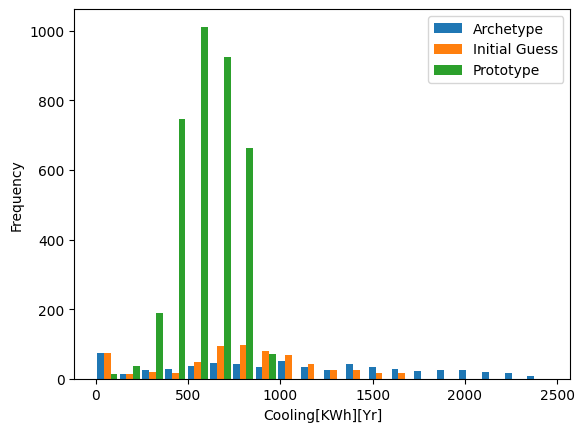

In [66]:
dataset = Dataset(q=0.7)
dataset.Plot('Cooling[KWh][Yr]', bins=20)

Heating[KWh][Yr]


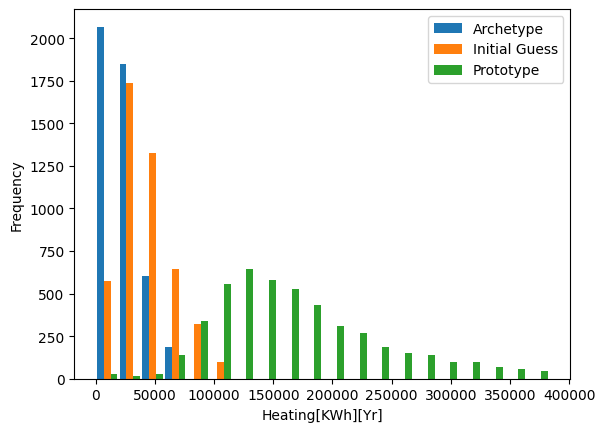

Cooling[KWh][Yr]


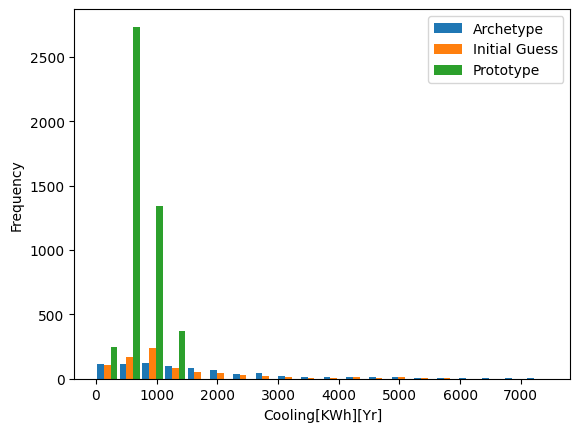

Equipment[KWh][Yr]


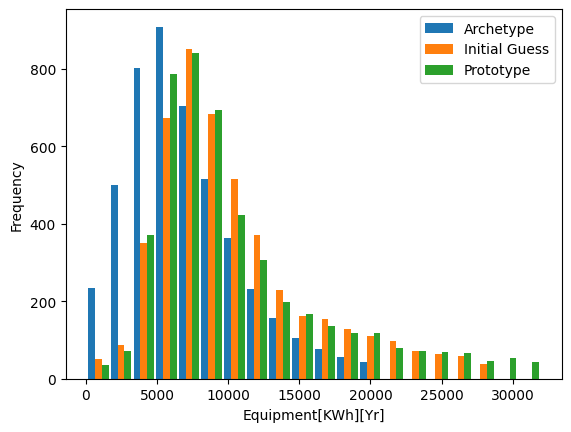

Lighting[KWh][Yr]


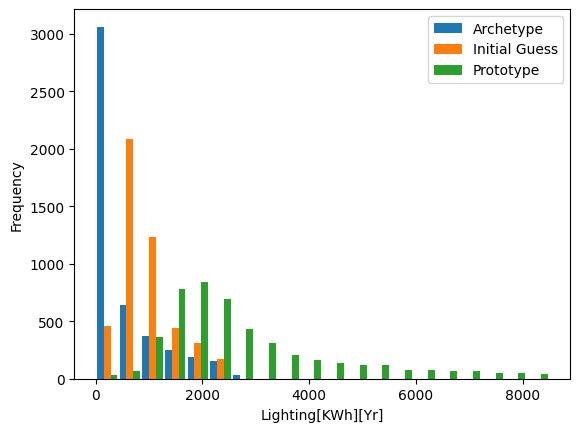

HotWater[KWh][Yr]


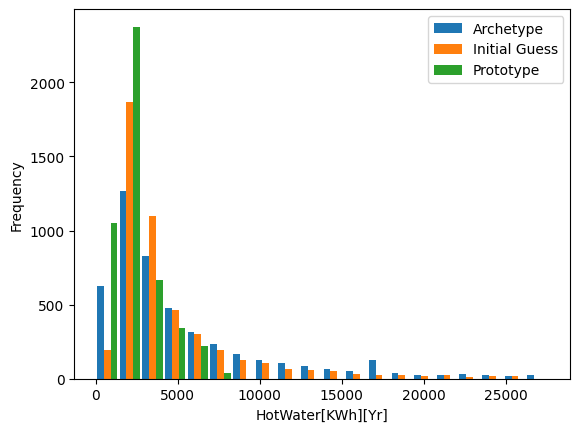

EnergyUse[KWh][Yr]


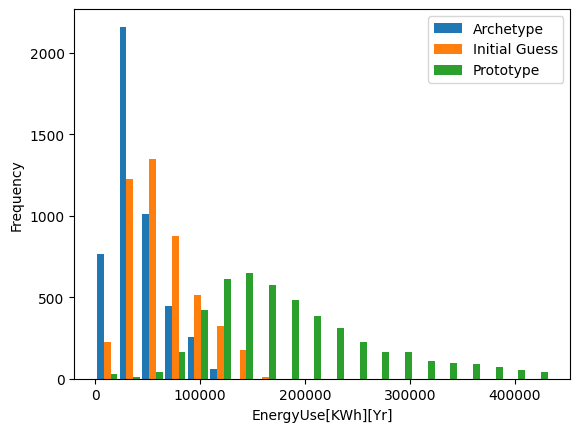

Heating[KWh_m2][Yr]


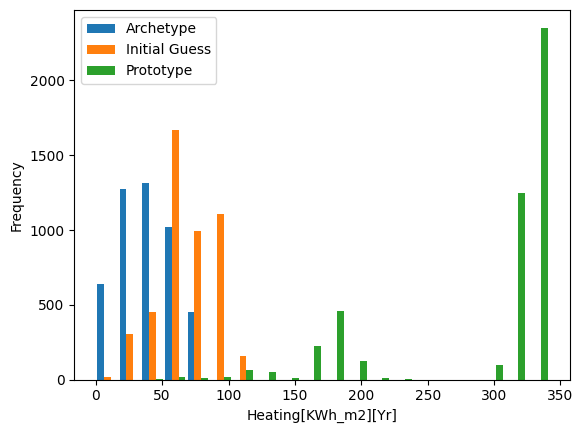

Cooling[KWh_m2][Yr]


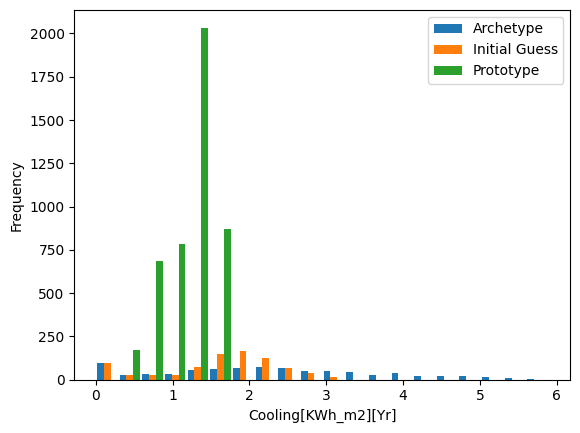

Equipment[KWh_m2][Yr]


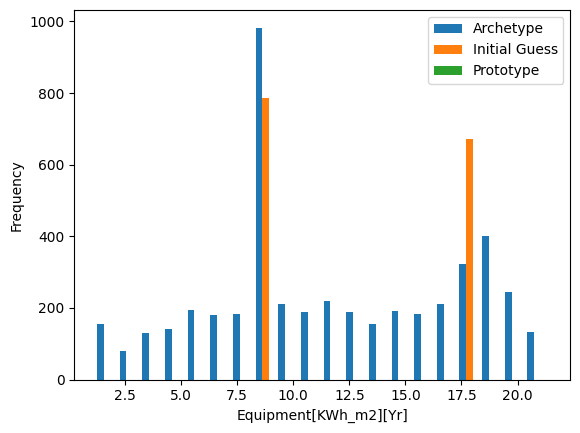

Lighting[KWh_m2][Yr]


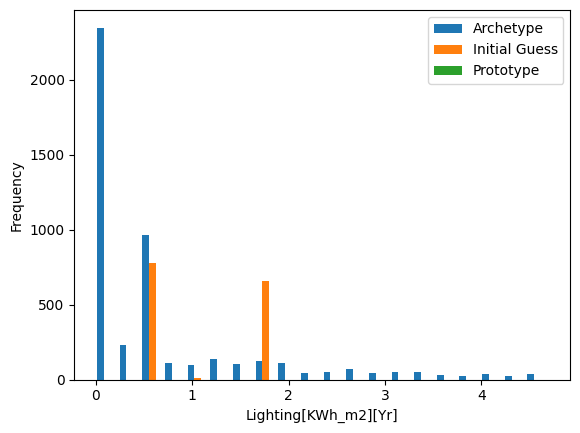

HotWater[KWh_m2][Yr]


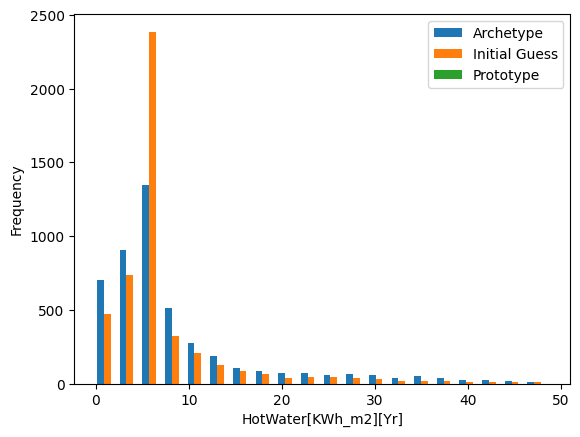

EUI[KWh_m2][Yr]


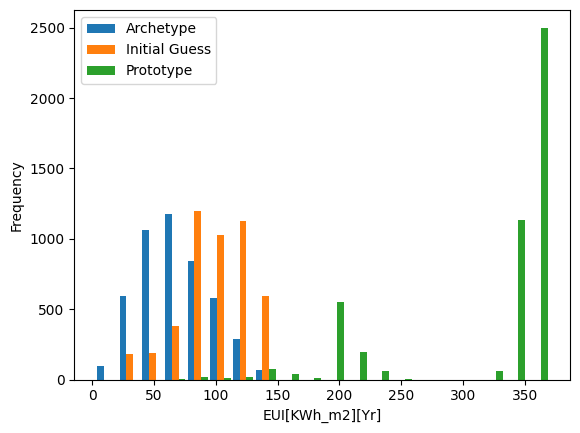

Gas[kWh][Yr]


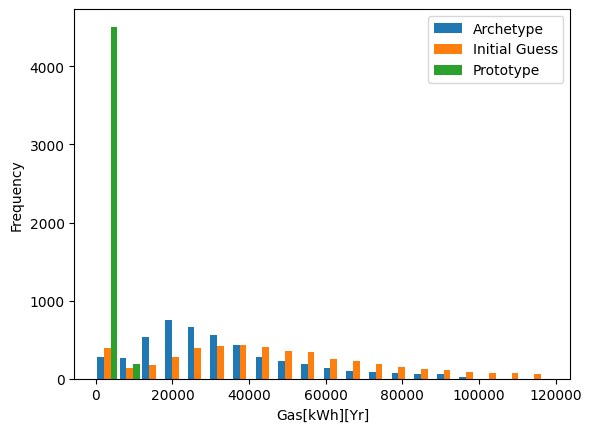

Electricity[kWh][Yr]


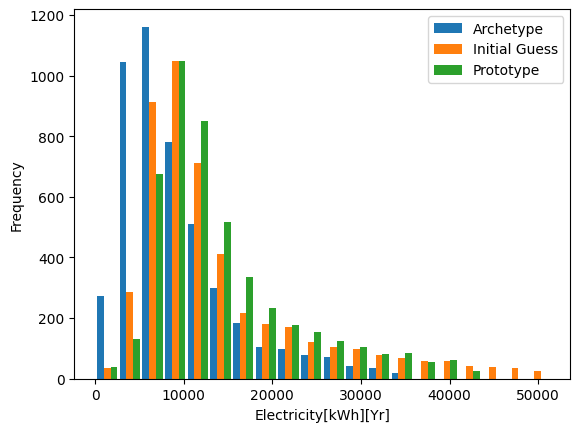

Gas[kWh_m2][Yr]


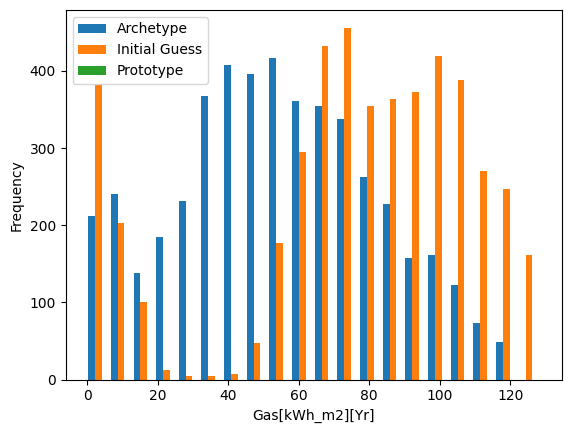

Electricity[kWh_m2][Yr]


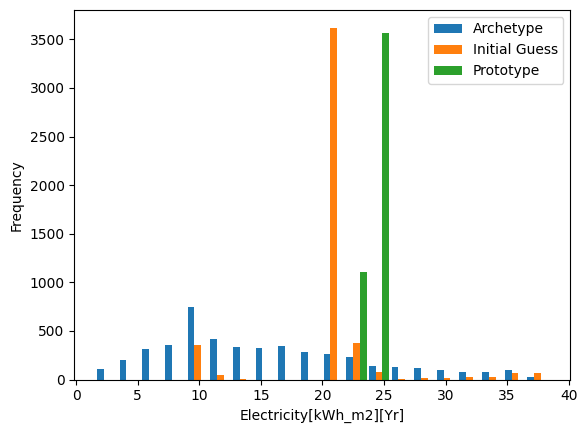

CO2[kg][Yr]


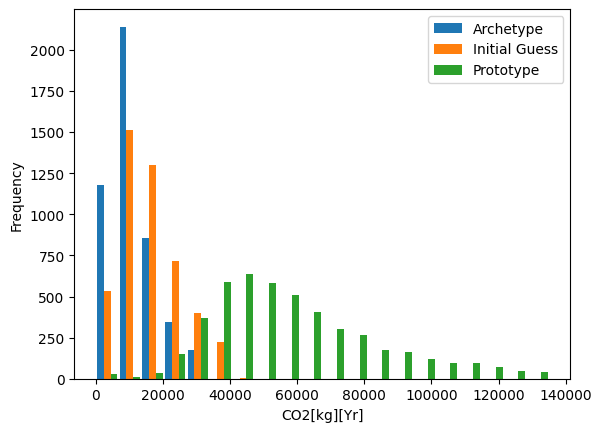

CO2_Gas[kg][Yr]


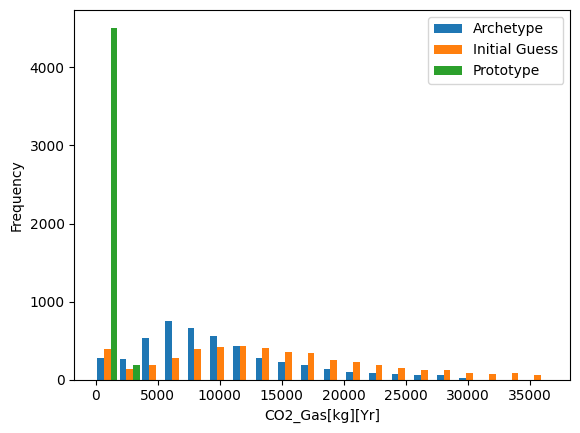

CO2_Electricity[kg][Yr]


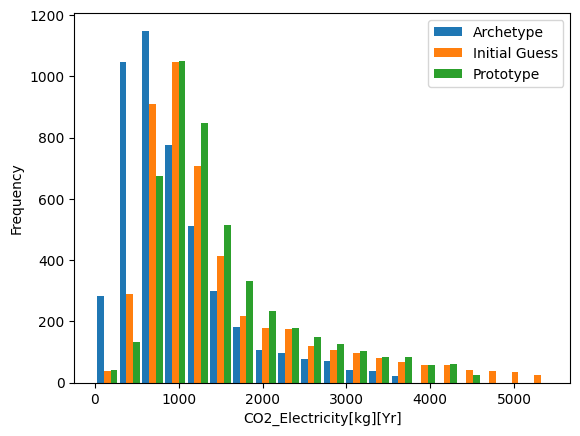

CO2[kg_m2][Yr]


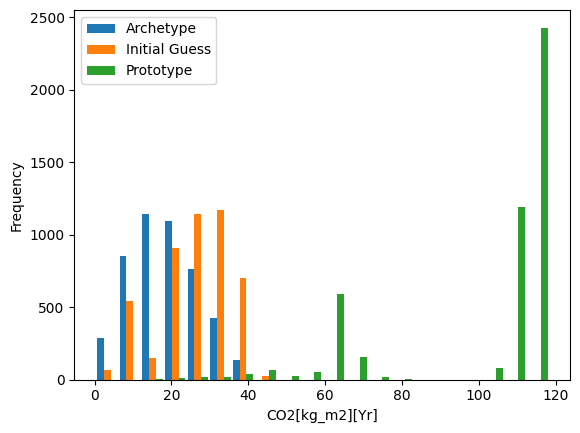

PEPC[KWh_p][Yr]


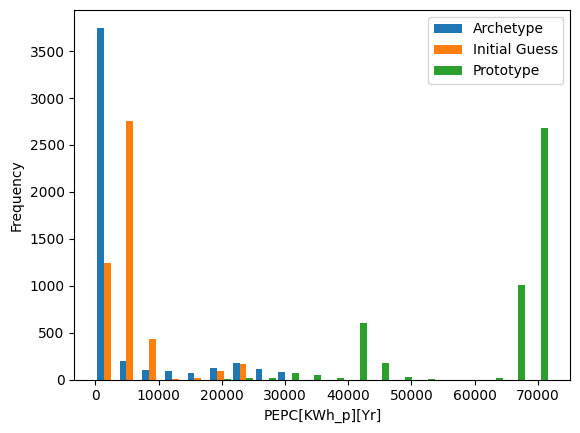

CO2PC[kg_p][Yr]


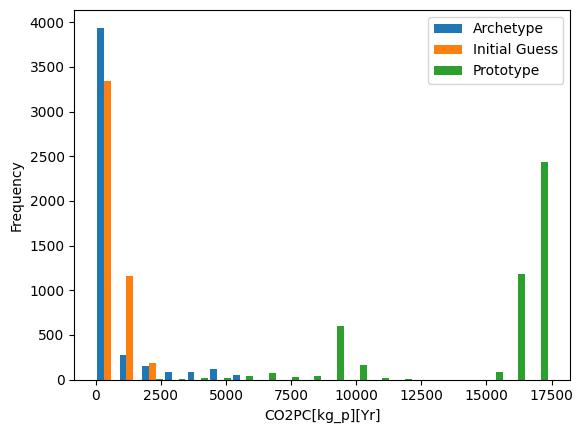

GasError[%][Yr]


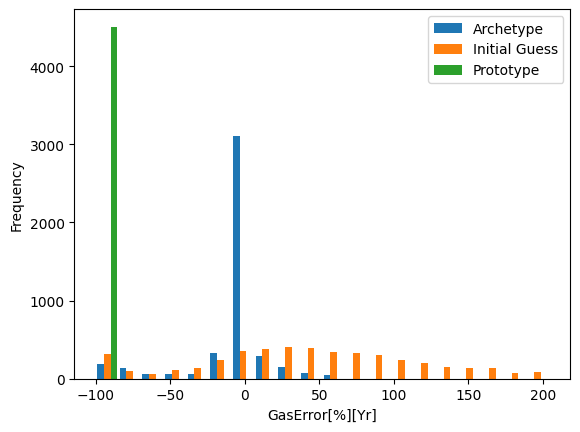

ElecError[%][Yr]


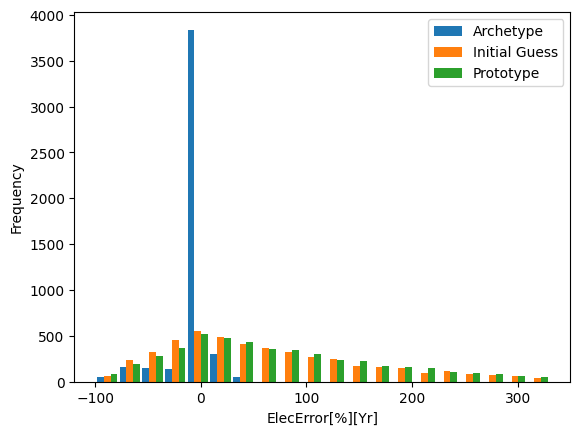

roof_UVal[W_m2K]_ESL


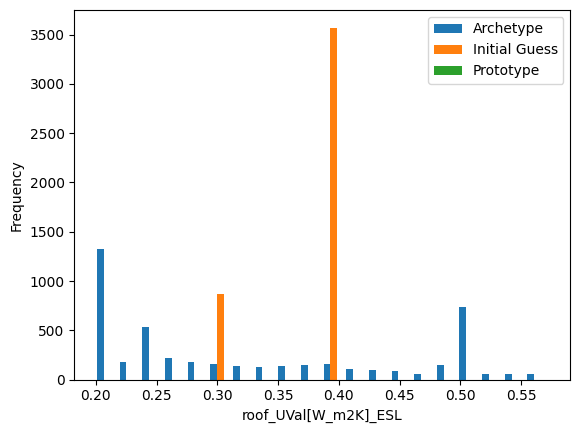

wall_UVal[W_m2K]_ESL


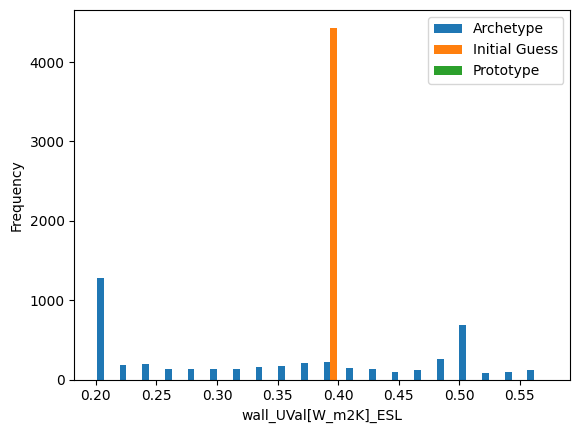

GlazingUVal_ESL


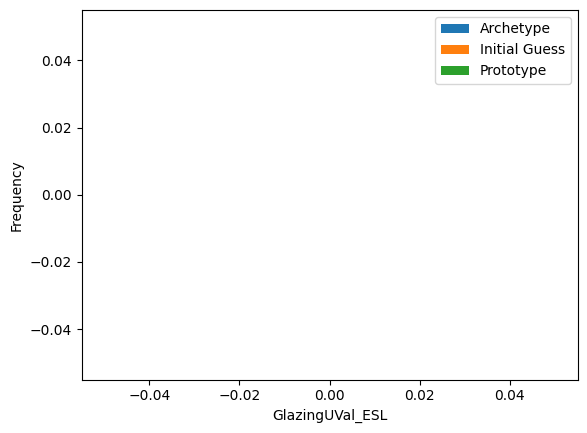

GlazingSHGC_ESL


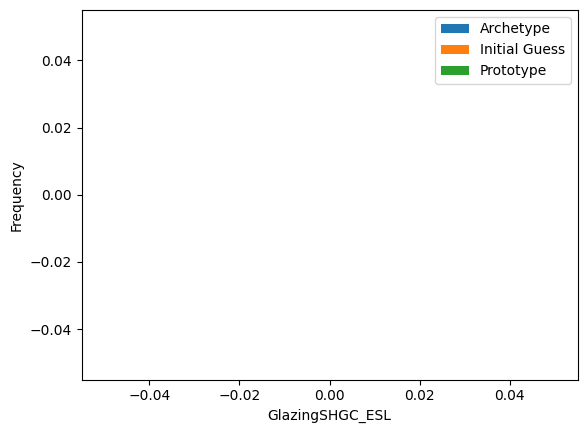

infiltr[ACH]_ESL


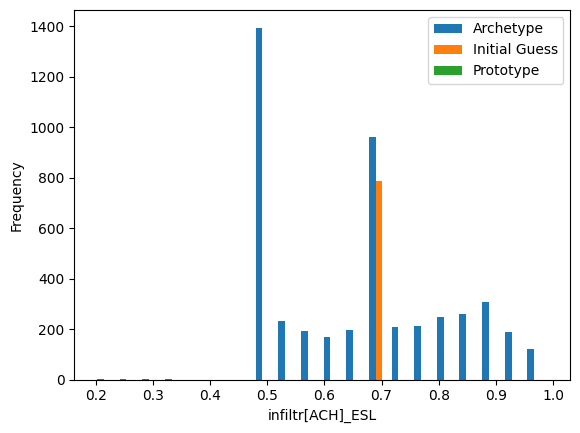

infiltr[m3_s_m2]_ESL


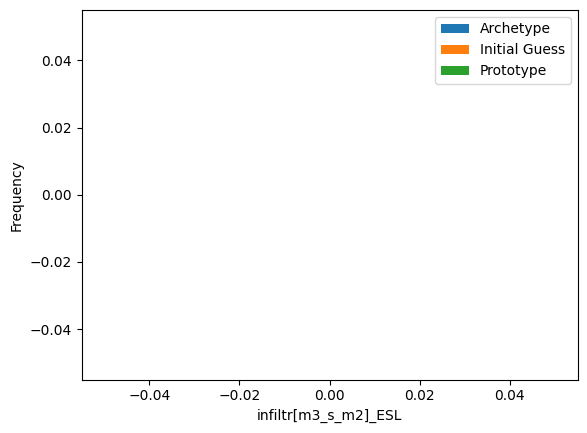

flowDHW[m3_h_P]_ESL


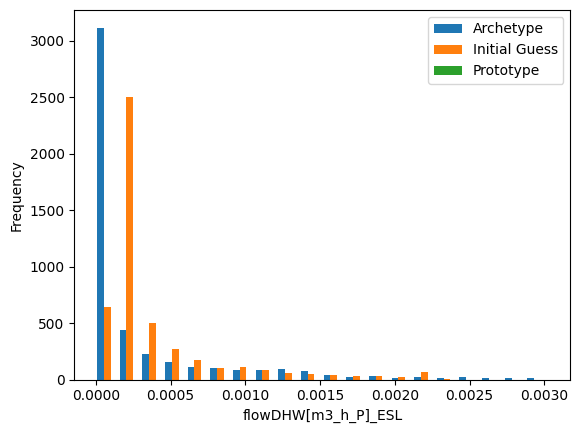

equipPowDen[W_m2]_ESL


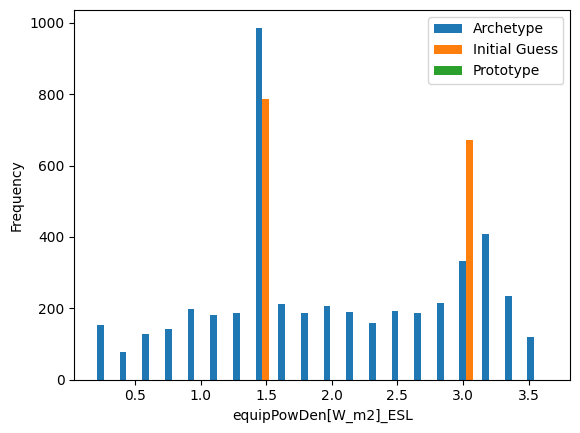

lightPowDen[W_m2]_ESL


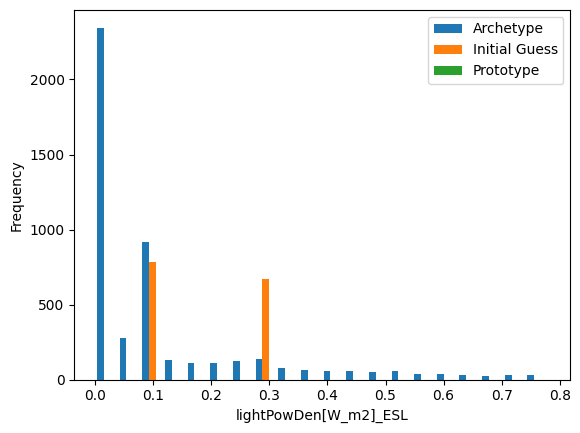

peopleDen[P_m2]_ESL


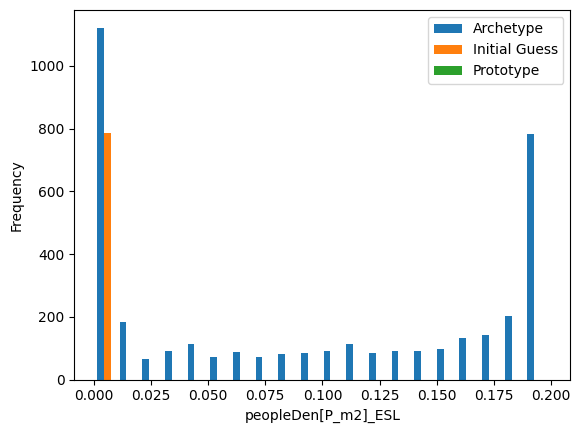

thermalMassClass_ESL


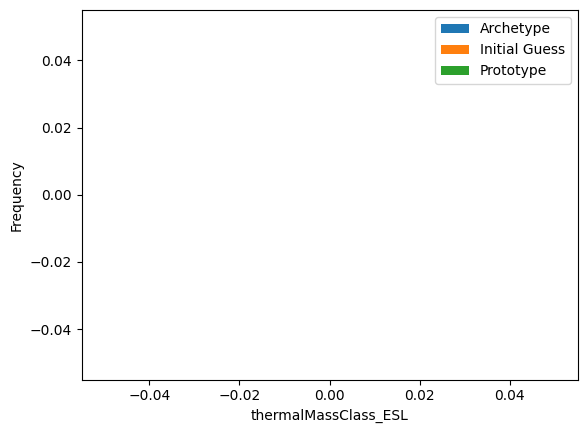

gasPowDen[W_m2]_ESL


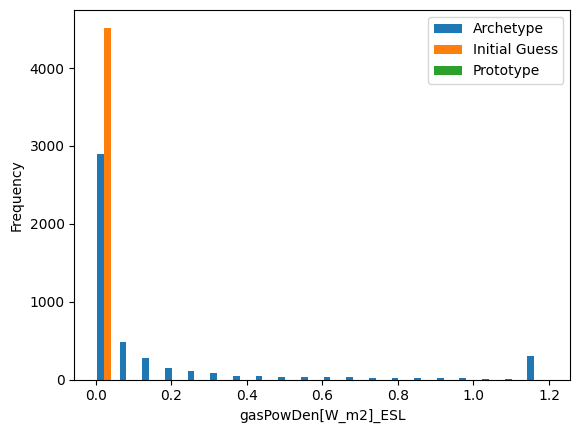

heatingSetPoint[degC]_ESL


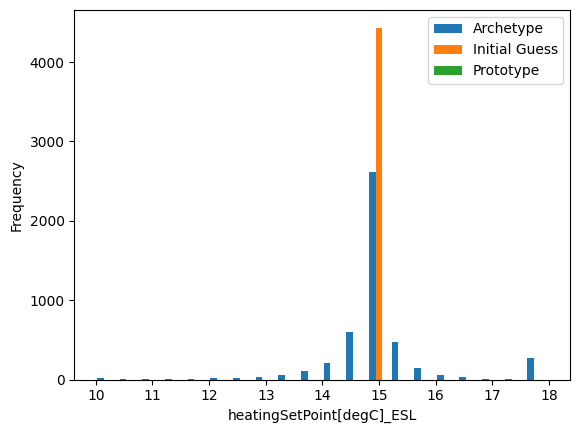

coolingSetPoint[degC]_ESL


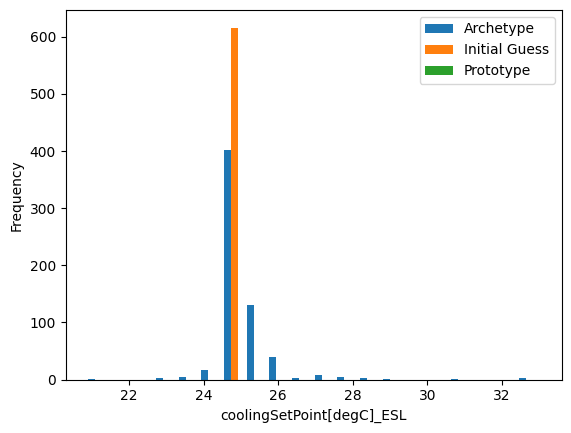

GasEquipment[KWh][Yr]


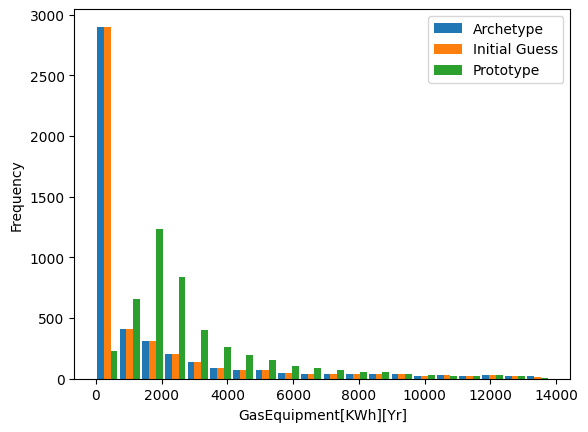

SimulatedCoolingCOP


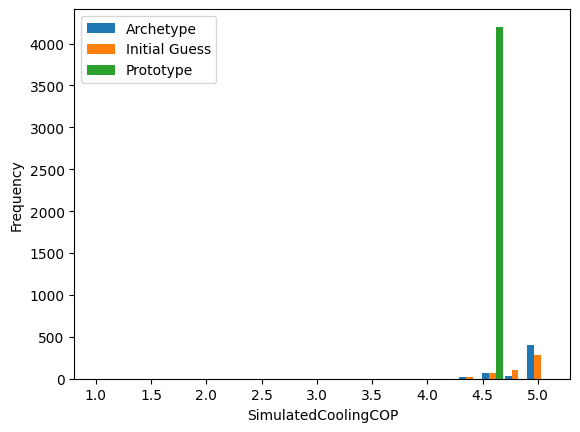

SimulatedHeatingCOP


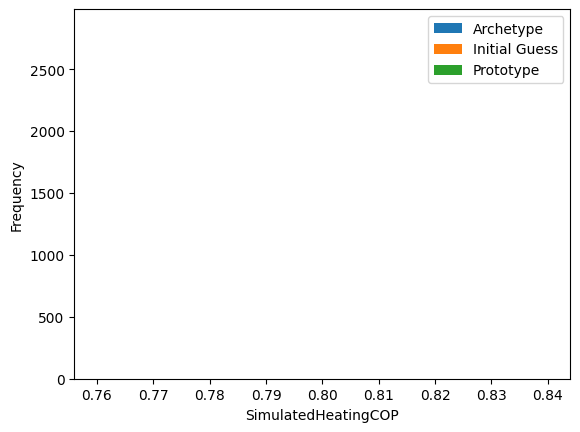

NominalHeatingCOP


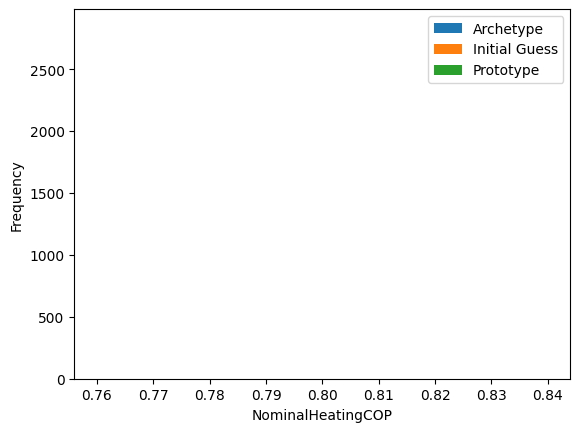

NominalCoolingCOP


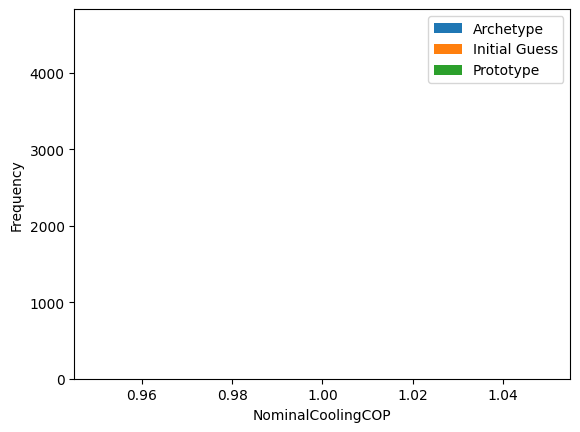

In [69]:
dataset = Dataset(q=0.9)
for column in columns_to_try:
    print(column)
    dataset.Plot(column, bins=20, )

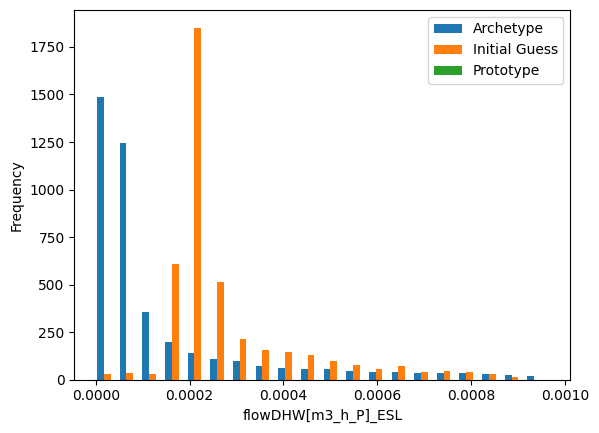

In [31]:
dataset = Dataset(q=0.8)
dataset.Plot("flowDHW[m3_h_P]_ESL", bins=20, )


In [ ]:


Q = 0.9
colors = [[0.8, 0.8, 0.8, 1]] + plt.cm.winter(np.linspace(0.3, 0.9, 3)).tolist()

# Define the datasets (post-calibration)
calibrated_electricity = archetype['Electricity[kWh][Yr]'][archetype['Electricity[kWh][Yr]'] < archetype['Electricity[kWh][Yr]'].quantile(Q)]
billed_electricity = archetype['el_annual_2020'][archetype['el_annual_2020'] < archetype['el_annual_2020'].quantile(Q)]
calibrated_gas = archetype['Gas[kWh][Yr]'][archetype['Gas[kWh][Yr]'] < archetype['Gas[kWh][Yr]'].quantile(Q)]
billed_gas = archetype['gs_annual_2020'].apply(thm2kwh).fillna(0)
billed_gas = billed_gas[billed_gas < billed_gas.quantile(Q)]

# Define the datasets (pre-calibration)
calibrated_electricity_pre = initial_guess['Electricity[kWh][Yr]'][initial_guess['Electricity[kWh][Yr]'] < initial_guess['Electricity[kWh][Yr]'].quantile(Q)]
calibrated_gas_pre = initial_guess['Gas[kWh][Yr]'][initial_guess['Gas[kWh][Yr]'] < initial_guess['Gas[kWh][Yr]'].quantile(Q)]

prototype_electricity = prototype['Electricity[kWh][Yr]'][prototype['Electricity[kWh][Yr]'] < prototype['Electricity[kWh][Yr]'].quantile(Q)]
prototype_gas = prototype['Gas[kWh][Yr]'][prototype['Gas[kWh][Yr]'] < prototype['Gas[kWh][Yr]'].quantile(Q)]

# Define shared bins
bins = 20

# Electricity bins
min_elec = min(calibrated_electricity.min(), billed_electricity.min(), calibrated_electricity_pre.min(), prototype_electricity.min())
max_elec = max(calibrated_electricity.max(), billed_electricity.max(), calibrated_electricity_pre.max(), prototype_electricity.max())
bin_edges_elec = np.linspace(min_elec, max_elec, bins + 1)

# Gas bins
min_gas = min(calibrated_gas.min(), billed_gas.min(), calibrated_gas_pre.min(), prototype_gas.min())
max_gas = max(calibrated_gas.max(), billed_gas.max(), calibrated_gas_pre.max(), prototype_gas.max())
bin_edges_gas = np.linspace(min_gas, max_gas, bins + 1)

# Compute histogram counts
simulated_elec_counts, _ = np.histogram(calibrated_electricity, bins=bin_edges_elec, density=True)
billed_elec_counts, _ = np.histogram(billed_electricity, bins=bin_edges_elec, density=True)
simulated_elec_pre_counts, _ = np.histogram(calibrated_electricity_pre, bins=bin_edges_elec, density=True)
prototype_elec_counts, _ = np.histogram(prototype_electricity, bins=bin_edges_elec, density=True)

calibrated_gas_counts, _ = np.histogram(calibrated_gas, bins=bin_edges_gas, density=True)
billed_gas_counts, _ = np.histogram(billed_gas, bins=bin_edges_gas, density=True)
calibrated_gas_pre_counts, _ = np.histogram(calibrated_gas_pre, bins=bin_edges_gas, density=True)
prototype_gas_counts, _ = np.histogram(prototype_gas, bins=bin_edges_gas, density=True)

# Define bin centers for alignment
bin_centers_elec = (bin_edges_elec[:-1] + bin_edges_elec[1:]) / 2
bin_centers_gas = (bin_edges_gas[:-1] + bin_edges_gas[1:]) / 2

# Define bar widths
bar_width_elec = (bin_edges_elec[1] - bin_edges_elec[0]) * 0.2
bar_width_gas = (bin_edges_gas[1] - bin_edges_gas[0]) * 0.2

# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharey=True, layout='tight')
axs = [ax]
# Electricity subplot
axs[0].bar(bin_centers_elec - 1.5 * bar_width_elec, billed_elec_counts, width=bar_width_elec, color=colors[0], label='Ground truth', zorder=10)
axs[0].bar(bin_centers_elec - 0.5 * bar_width_elec, simulated_elec_counts, width=bar_width_elec, color=colors[1], label='Archetype calibrated', zorder=10)
axs[0].bar(bin_centers_elec + 0.5 * bar_width_elec, simulated_elec_pre_counts, width=bar_width_elec, color=colors[2], label='Archetype initial guess',  zorder=10)

axs[0].bar(bin_centers_elec + 1.5 * bar_width_elec, prototype_elec_counts, width=bar_width_elec, color=colors[3], label='DOE Prototype buildings', zorder=10)

# KDE curves for electricity
sns.kdeplot(billed_electricity, color=colors[0], ax=axs[0], linewidth=1, label='Ground truth KDE', linestyle="solid", fill=True, alpha=0.1)
sns.kdeplot(calibrated_electricity, color=colors[1], ax=axs[0], linewidth=1, label='Archetype calibrated KDE', linestyle="dashed", fill=True, alpha=0.1)
sns.kdeplot(calibrated_electricity_pre, color=colors[2], ax=axs[0], linewidth=1, label='Archetype initial guess KDE', linestyle="dotted", fill=True, alpha=0.1)

sns.kdeplot(prototype_electricity, color=colors[3], ax=axs[0], linewidth=1, label='DOE Prototype buildings KDE', linestyle="dotted", fill=True, alpha=0.1)

axs[0].axvline(billed_electricity.mean(), color=colors[0], linewidth=1, linestyle="solid", label='Ground truth mean')
axs[0].axvline(calibrated_electricity.mean(), color=colors[1], linewidth=1, linestyle="dashed", label='Archetype calibrated mean')
axs[0].axvline(calibrated_electricity_pre.mean(), color=colors[2], linewidth=1, linestyle="dotted", label='Archetype initial guess mean')

axs[0].axvline(prototype_electricity.mean(), color=colors[3], linewidth=1, linestyle="dotted", label='DOE Prototype buildings mean')

axs[0].set_xlabel('Annual electricity consumption (kWh)')
axs[0].set_ylabel('Number of buildings')
axs[0].set_title('Distribution of electricity consumption')
axs[0].legend()
#axs[0].set_yticks(np.arange(0, 801, 100) / calibrated_electricity.shape[0], np.arange(0, 801, 100) )
axs[0].set_xlim(0, 40000)
axs[0].set_yticks(np.arange(0, 5001, 500) / calibrated_electricity.shape[0] / (bin_centers_elec[1] - bin_centers_elec[0]), np.arange(0, 5001, 500) )
axs[0].set_ylim(0, 0.9/5000)

if save_fig: plt.savefig('print/archetype_distribution_comparison_elec.png', bbox_inches='tight')
if save_fig: plt.savefig('print/archetype_distribution_comparison_elec.pdf', bbox_inches='tight')



# -------------------#




fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharey=True, layout='tight')
axs = [0, ax]
# Gas subplot
colors = colors[::-1]
colors = [[0.8, 0.8, 0.8, 1]] + plt.cm.spring(np.linspace(0.2, 0.9, 3)).tolist()
axs[1].bar(bin_centers_gas - 1.5 * bar_width_gas, billed_gas_counts, width=bar_width_gas, color=colors[0], label='Ground truth', zorder=10)
axs[1].bar(bin_centers_gas - 0.5 * bar_width_gas, calibrated_gas_counts, width=bar_width_gas, color=colors[1], label='Archetype calibrated', zorder=10)
axs[1].bar(bin_centers_gas + 0.5 * bar_width_gas, calibrated_gas_pre_counts, width=bar_width_gas, color=colors[2], label='Archetype initial guess', zorder=10)

axs[1].bar(bin_centers_gas + 1.5 * bar_width_gas, prototype_gas_counts, width=bar_width_gas, color=colors[3], label='DOE Prototype buildings', zorder=10)

# KDE curves for gas
sns.kdeplot(billed_gas, color=colors[0], ax=axs[1], linewidth=1, label='Ground truth KDE', linestyle="solid", fill=True, alpha=0.1)
sns.kdeplot(calibrated_gas, color=colors[1], ax=axs[1], linewidth=1, label='Archetype calibrated KDE', linestyle="dashed", fill=True, alpha=0.1)
sns.kdeplot(calibrated_gas_pre, color=colors[2], ax=axs[1], linewidth=1, label='Archetype initial guess KDE', linestyle="dotted", fill=True, alpha=0.1)

sns.kdeplot(prototype_gas, color=colors[3], ax=axs[1], linewidth=1, label='DOE Prototype buildings KDE', linestyle="dotted", fill=True, alpha=0.1)

axs[1].axvline(billed_gas.mean(), color=colors[0], linewidth=1, linestyle="solid", label='Ground truth mean')
axs[1].axvline(calibrated_gas.mean(), color=colors[1], linewidth=1, linestyle="dashed", label='Archetype calibrated mean')
axs[1].axvline(calibrated_gas_pre.mean(), color=colors[2], linewidth=1, linestyle="dotted", label='Archetype initial guess mean')

axs[1].axvline(prototype_gas.mean(), color=colors[3], linewidth=1, linestyle="dotted", label='DOE Prototype buildings mean')

axs[1].set_xlabel('Annual gas consumption (kWh)')
axs[1].set_title('Distribution of gas consumption')
axs[1].legend()

axs[1].set_xlim(0, 80000)

axs[1].set_yticks([], [])


#axs[1].set_yticks(np.arange(0, 2601, 200) / calibrated_electricity.shape[0] / (bin_centers_gas[1] - bin_centers_gas[0]), [] )
axs[1].set_yticks(np.arange(0, 5001, 500) / calibrated_electricity.shape[0] / (bin_centers_elec[1] - bin_centers_elec[0]), np.arange(0, 5001, 500) )
axs[1].set_ylim(0, 0.9/5000)

axs[1].set_ylabel('')
#fig.suptitle('Distribution of pre- and post-calibration simulation and billed energy consumption')
plt.tight_layout()


if save_fig: plt.savefig('print/archetype_distribution_comparison_gas.png', bbox_inches='tight')
if save_fig: plt.savefig('print/archetype_distribution_comparison_gas.pdf', bbox_inches='tight')